In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, GPT2Tokenizer, GPT2DoubleHeadsModel
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset, SequentialSampler)
from tqdm import trange

/home/test/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/test/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/test/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/test/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
directory = "../data/SST2/"

In [3]:
train = pd.read_csv(directory+"train.tsv", sep = "\t")
#test = pd.read_csv(directory+"test.tsv", sep = "\t")
dev = pd.read_csv(directory+"dev.tsv", sep = "\t")

In [7]:
model_name = "BERT"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
if model_name == "BERT":
    train_sentences = train['sentence'].values
    train_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in train_sentences]
    train_labels = train['label'].values

    test_sentences = dev['sentence'].values
    test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]
    test_labels = dev['label'].values
    
elif model_name == "gpt2":
    train_sentences = train['sentence'].values
    #train_sentences = ["_start_ " + sentence + " _classify_" for sentence in train_sentences]
    train_labels = train['label'].values
    
    test_sentences = dev['sentence'].values
    #test_sentences = ["_start_ " + sentence + " _classify_" for sentence in test_sentences]
    test_labels = dev['label'].values

In [8]:
max_length = 128
if model_name == "BERT":
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
elif model_name == "gpt2":
    special_tokens = ["_start_", "_classify_"]
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2', do_lower_case=True)
    tokenizer.add_tokens(special_tokens)

In [9]:
train_input_ids = [tokenizer.encode(sent, add_special_tokens = False) for sent in train_sentences]
test_input_ids = [tokenizer.encode(sent, add_special_tokens = False) for sent in test_sentences]

In [9]:
start = tokenizer.convert_tokens_to_ids("_start_")
classify = tokenizer.convert_tokens_to_ids("_classify_")
train_input_ids = [[start] + tokenizer.encode(sent)[:(max_length-2)] + [classify] for sent in train_sentences]
test_input_ids = [[start] + tokenizer.encode(sent)[:(max_length-2)] + [classify] for sent in test_sentences]

In [10]:
MAX_LEN = 128
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [12]:
train_attention_masks = []
test_attention_masks = []

for seq in train_input_ids:
    seq_mask = [float(i>0) for i in seq]
    train_attention_masks.append(seq_mask)
    
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

In [12]:
cls_position_train = np.argmax(train_input_ids==classify,axis=1)
cls_position_test = np.argmax(test_input_ids==classify,axis=1)

In [13]:
train_inputs = torch.tensor(train_input_ids)
train_masks = torch.tensor(train_attention_masks)
train_labels = torch.tensor(train_labels)
#train_cls_positions= torch.tensor(cls_position_train)

test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
#test_cls_positions=torch.tensor(cls_position_test)

In [14]:
batch_size = 16
#train_data = TensorDataset(train_inputs, train_masks, train_labels, train_cls_positions)
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

#test_data = TensorDataset(test_inputs, test_masks, test_labels, test_cls_positions)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [15]:
if model_name == "BERT":
    #model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model = torch.load('./SST2-finetuned-BERT-v2.pt')
elif model_name == "gpt2":
    #model = GPT2DoubleHeadsModel.from_pretrained("gpt2", num_labels = 2)
    model = torch.load('./SST2-finetuned-GPT2-v2.pt')
    model.resize_token_embeddings(len(tokenizer))
model = model.cuda()

/home/test/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'transformers.modeling_bert.BertForSequenceClassification' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/test/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'transformers.modeling_bert.BertModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/test/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'transformers.modeling_bert.BertEmbeddings' has changed. you can retrieve the origi

In [16]:
linear = nn.Linear(768*128, 2).to(torch.device("cuda:0"))

In [17]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*3)  # PyTorch scheduler

In [18]:
if model_name=="BERT":
  model.bert.config.output_hidden_states = True
  model.bert.config.is_decoder = False
  model.bert.encoder.output_hidden_states = True
  for i in range(0,len(model.bert.encoder.layer)): 
    model.bert.encoder.layer[i].is_decoder = False
    model.bert.encoder.layer[i].output_hidden_states = True
else:
    model.transformer.output_hidden_states = True

In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    #b_input_ids, b_input_mask, b_labels, b_cls_positions = batch
    b_input_ids, b_input_mask, b_labels = batch
    
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    if model_name == "BERT":
        outputs = model.bert(b_input_ids, attention_mask=b_input_mask)
        h0 = outputs[2][0] ## Here we are using embeddings layer 
        logits = linear(h0.view(-1,98304)) ## We flat the embeddings
    else:
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, mc_labels=b_labels, mc_token_ids =b_cls_positions)
    
    loss_fct = CrossEntropyLoss()
    loss=loss_fct(logits.view(-1, logits.size(-1)),
                          b_labels.view(-1))
    
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    #b_input_ids, b_input_mask, b_labels, b_cls_positions = batch
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      if model_name == "BERT":
        outputs = model.bert(b_input_ids, attention_mask=b_input_mask)
        h0 = outputs[2][0] ## Here we are using embeddings layer 
        logits = linear(h0.view(-1,98304)) ## We flat the embeddings
      else:
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, mc_token_ids =b_cls_positions)[1]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6756264284146937


Epoch:  33%|███▎      | 1/3 [06:21<12:42, 381.01s/it]

Validation Accuracy: 0.5693181818181818
Train loss: 0.634762515506382


Epoch:  67%|██████▋   | 2/3 [12:42<06:21, 381.23s/it]

Validation Accuracy: 0.6477272727272727
Train loss: 0.5910472514510438


Epoch: 100%|██████████| 3/3 [19:04<00:00, 381.32s/it]

Validation Accuracy: 0.6284090909090909


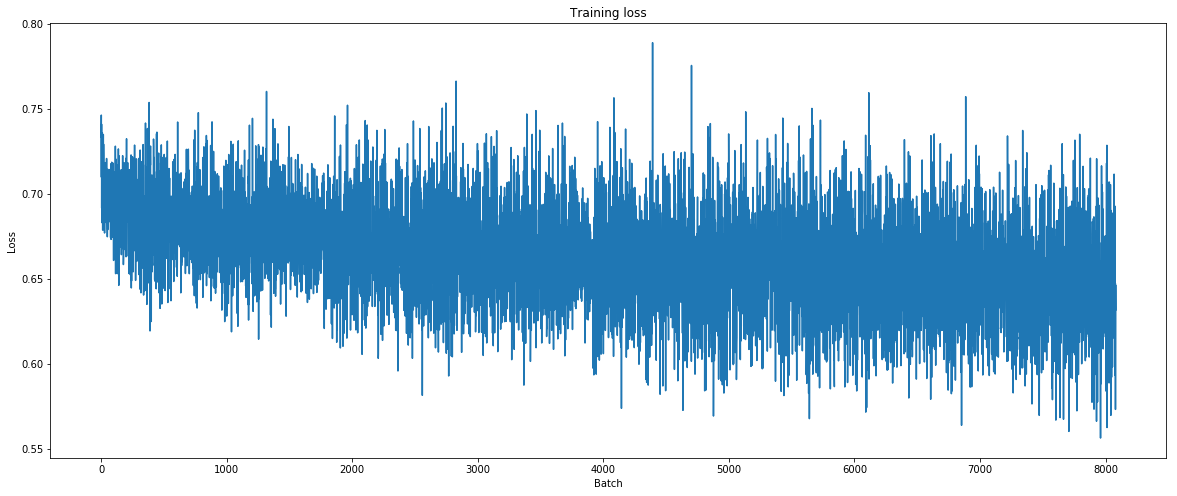

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_sets[2])
plt.show()

In [29]:
torch.cuda.empty_cache()
model.eval()
preds = []

for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    #b_input_ids, b_input_mask, b_labels, b_cls_positions = batch
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        if model_name == "BERT":
            outputs = model.bert(b_input_ids, attention_mask=b_input_mask)
            h0 = outputs[2][0] ## Here we are using embeddings layer 
            logits = linear(h0.view(-1,98304)) ## We flat the embeddings
        else:
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, mc_token_ids = b_cls_positions)[1]
    
    logits = logits.detach().cpu().numpy()
    preds.append(logits)

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
predictions = []

print(len(np.array(test_labels)))
for pred in preds:
    p = np.argmax(pred, axis = 1)
    for label in p:
        predictions.append(label)
print(len(predictions))
print(classification_report(np.array(test_labels), predictions, digits = 4))
print("Accuracy: ", accuracy_score(np.array(test_labels), predictions))

872
872
              precision    recall  f1-score   support

           0     0.5805    0.9019    0.7063       428
           1     0.7971    0.3716    0.5069       444

    accuracy                         0.6319       872
   macro avg     0.6888    0.6367    0.6066       872
weighted avg     0.6908    0.6319    0.6048       872

Accuracy:  0.6318807339449541
